## Model Training

#### 1.1 Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [2]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#### Import the CSV Data as Pandas DataFrame

In [ ]:
df = pd.read_csv(r'data\heart_disease.csv')

#### Show Top 5 Records

In [4]:
df.head()

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,...,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level,Heart Disease Status
0,56.0,Male,153.0,155.0,High,Yes,Yes,No,24.991591,Yes,...,No,High,Medium,7.633228,Medium,342.0,NaN,12.969246,12.387250,No
1,69.0,Female,146.0,286.0,High,No,Yes,Yes,25.221799,No,...,No,Medium,High,8.744034,Medium,133.0,157.0,9.355389,19.298875,No
2,46.0,Male,126.0,216.0,Low,No,No,No,29.855447,No,...,Yes,Low,Low,4.440440,Low,393.0,92.0,12.709873,11.230926,No
3,32.0,Female,122.0,293.0,High,Yes,Yes,No,24.130477,Yes,...,Yes,Low,High,5.249405,High,293.0,94.0,12.509046,5.961958,No
4,60.0,Male,166.0,242.0,Low,Yes,Yes,Yes,20.486289,Yes,...,No,Low,High,7.030971,High,263.0,154.0,10.381259,8.153887,No


### Data PreProcessing

In [5]:
# Data Preprocessing
# Impute missing numerical values with medians
medians = {
    "Age": 49, "Blood Pressure": 150, "Cholesterol Level": 226, "BMI": 29.08,
    "Sleep Hours": 7.00, "Triglyceride Level": 250, "Fasting Blood Sugar": 120,
    "CRP Level": 7.47, "Homocysteine Level": 12.41
}
numerical_cols = list(medians.keys())
for col in numerical_cols:
    df[col] = df[col].fillna(medians[col])

# Impute missing categorical values with modes
modes = {
    "Gender": "Female", "Exercise Habits": "High", "Smoking": "Yes",
    "Family Heart Disease": "Yes", "Diabetes": "No", "High Blood Pressure": "Yes",
    "Low HDL Cholesterol": "No", "High LDL Cholesterol": "Yes", "Alcohol Consumption": "Low",
    "Stress Level": "Medium", "Sugar Consumption": "Medium"
}
categorical_cols = list(modes.keys())
for col in categorical_cols:
    df[col] = df[col].replace("None", modes[col]).fillna(modes[col])

# Convert boolean-like columns to consistent Yes/No
boolean_cols = ["Smoking", "Family Heart Disease", "Diabetes", "High Blood Pressure",
                "Low HDL Cholesterol", "High LDL Cholesterol", "Heart Disease Status"]
for col in boolean_cols:
    df[col] = df[col].apply(lambda x: "Yes" if str(x).lower() == "yes" else "No")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols + boolean_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

#### Preparing X and Y variables

In [6]:
X = df.drop(columns=['Heart Disease Status'],axis=1)
feature_names = X.columns.tolist()
X.head()

,Age,Gender,Blood Pressure,Cholesterol Level,Exercise Habits,Smoking,Family Heart Disease,Diabetes,BMI,High Blood Pressure,Low HDL Cholesterol,High LDL Cholesterol,Alcohol Consumption,Stress Level,Sleep Hours,Sugar Consumption,Triglyceride Level,Fasting Blood Sugar,CRP Level,Homocysteine Level
0,56.0,1,153.0,155.0,0,1,1,0,24.991591,1,1,0,0,2,7.633228,2,342.0,120.0,12.969246,12.387250
1,69.0,0,146.0,286.0,0,0,1,1,25.221799,0,1,0,2,0,8.744034,2,133.0,157.0,9.355389,19.298875
2,46.0,1,126.0,216.0,1,0,0,0,29.855447,0,1,1,1,1,4.440440,1,393.0,92.0,12.709873,11.230926
3,32.0,0,122.0,293.0,0,1,1,0,24.130477,1,0,1,1,0,5.249405,0,293.0,94.0,12.509046,5.961958
4,60.0,1,166.0,242.0,1,1,1,1,20.486289,1,0,0,1,0,7.030971,0,263.0,154.0,10.381259,8.153887


In [7]:
y = df['Heart Disease Status']
y

0       0
1       0
2       0
3       0
4       0
       ..
9995    1
9996    1
9997    1
9998    1
9999    1
Name: Heart Disease Status, Length: 10000, dtype: int64

In [8]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [9]:
X = preprocessor.fit_transform(X)

#### Create an Evaluate Function to give all metrics after model Training

In [10]:
# Define the evaluate function (corrected)
def evaluate(model_name, y_true, y_pred, y_pred_proba=None):

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)  # Use pos_label=1 (encoded "Yes")
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)
    
    # Calculate ROC-AUC if probabilities are provided
    roc_auc = None
    if y_pred_proba is not None:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    # Print the metrics
    print(f"\nEvaluation Metrics for {model_name}:")
    print("-" * 40)
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    if roc_auc is not None:
        print(f"ROC-AUC:   {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print("[[TN  FP]")
    print(" [FN  TP]]")
    print(cm)
    
    # Return metrics as a dictionary
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }
    return metrics

In [11]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((8000, 20), (2000, 20))

In [12]:
# Define a dictionary of classification models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "CatBoost": CatBoostClassifier(verbose=False, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

# Lists to store model names and F1-scores (for comparison)
model_list = []
f1_list = []

# Iterate over models, train, and evaluate
for i in range(len(models)):
    model_name = list(models.keys())[i]
    model = list(models.values())[i]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions on training set
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    
    # Evaluate on training set
    print(f"Training Set Evaluation for {model_name}")
    train_metrics = evaluate(model_name, y_train, y_train_pred, y_train_pred_proba)
    
    # Make predictions on test set
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = None
    if hasattr(model, "predict_proba"):
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Evaluate on test set
    print(f"\nTest Set Evaluation for {model_name}")
    test_metrics = evaluate(model_name, y_test, y_test_pred, y_test_pred_proba)
    
    # Store model name and F1-score (from test set)
    model_list.append(model_name)
    f1_list.append(test_metrics["f1_score"])
    
    print('='*35)
    print('\n')

# Print a summary of F1-scores
print("Summary of F1-Scores on Test Set:")
for name, f1 in zip(model_list, f1_list):
    print(f"{name}: {f1:.4f}")

Training Set Evaluation for Logistic Regression

Evaluation Metrics for Logistic Regression:
----------------------------------------
Accuracy:  0.7984
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.5331

Confusion Matrix:
[[TN  FP]
 [FN  TP]]
[[6387    0]
 [1613    0]]

Test Set Evaluation for Logistic Regression

Evaluation Metrics for Logistic Regression:
----------------------------------------
Accuracy:  0.8065
Precision: 0.0000
Recall:    0.0000
F1-Score:  0.0000
ROC-AUC:   0.4847

Confusion Matrix:
[[TN  FP]
 [FN  TP]]
[[1613    0]
 [ 387    0]]


Training Set Evaluation for K-Neighbors Classifier

Evaluation Metrics for K-Neighbors Classifier:
----------------------------------------
Accuracy:  0.8131
Precision: 0.6190
Recall:    0.1903
F1-Score:  0.2911
ROC-AUC:   0.7988

Confusion Matrix:
[[TN  FP]
 [FN  TP]]
[[6198  189]
 [1306  307]]

Test Set Evaluation for K-Neighbors Classifier

Evaluation Metrics for K-Neighbors Classifier:
--------------------------

In [13]:
pd.DataFrame(list(zip(model_list, f1_list)), columns=['model_name', 'f1_score']).sort_values(by=["f1_score"],ascending=False)

,model_name,f1_score
2,Decision Tree,0.193390
1,K-Neighbors Classifier,0.072144
5,XGBoost,0.056034
0,Logistic Regression,0.000000
3,Random Forest,0.000000
4,Support Vector Machine,0.000000
6,CatBoost,0.000000
7,AdaBoost,0.000000


In [14]:
pd.DataFrame(list(zip(model_list, f1_list)), columns=['model_name', 'recall']).sort_values(by=["recall"],ascending=False)

,model_name,recall
2,Decision Tree,0.193390
1,K-Neighbors Classifier,0.072144
5,XGBoost,0.056034
0,Logistic Regression,0.000000
3,Random Forest,0.000000
4,Support Vector Machine,0.000000
6,CatBoost,0.000000
7,AdaBoost,0.000000


### Decision Tree is the best model based on test set F1-score and recall. It identifies the most true positives (79), which is critical for a medical diagnosis task. However, its high false positive rate (351 FPs) suggests it may overpredict heart disease, which could lead to unnecessary tests or treatments.

### Select the Decision Tree model as it has the highest test set F1-score (0.1934) and recall (0.2041), which are critical for identifying heart disease cases in a medical context.

## Decision Tree

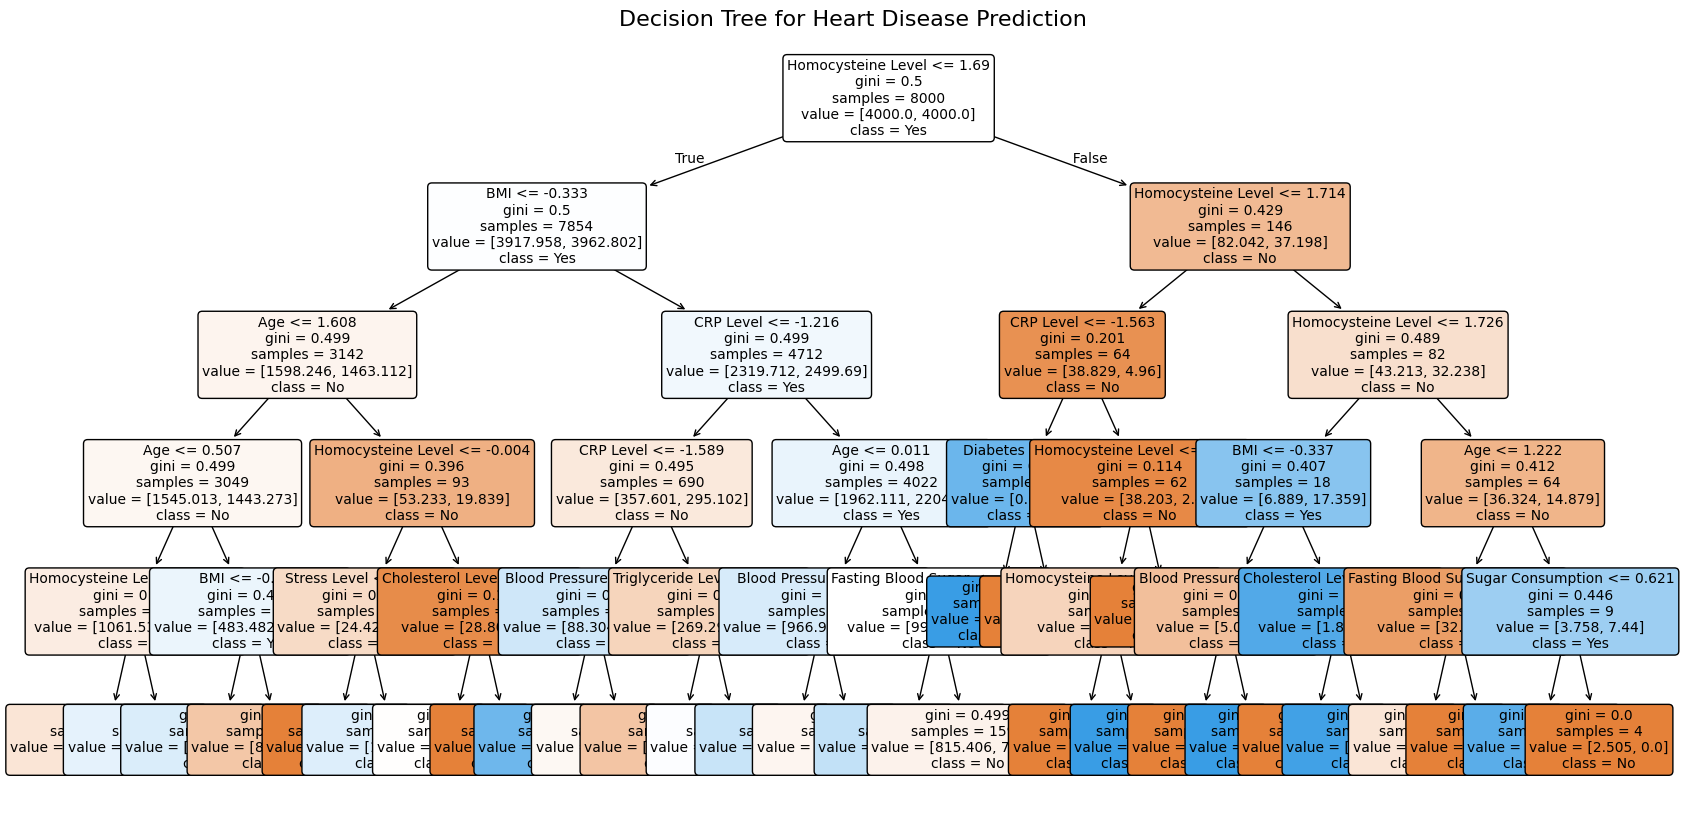

In [15]:
# Create and train the Decision Tree model with pruning and class weights
decision_tree = DecisionTreeClassifier(
    max_depth=5,              # Prune the tree to reduce overfitting
    class_weight='balanced',  # Handle class imbalance
    random_state=42
)
decision_tree.fit(X_train, y_train)

# Plot the Decision Tree
plt.figure(figsize=(20, 10))  # Set figure size for better readability
plot_tree(
    decision_tree,
    feature_names=feature_names,  # Use the stored feature names
    class_names=["No", "Yes"],    # Class names after encoding (0 = "No", 1 = "Yes")
    filled=True,                  # Color nodes based on class
    rounded=True,                 # Round the edges of nodes for better visuals
    fontsize=10                   # Font size for readability
)
plt.title("Decision Tree for Heart Disease Prediction", fontsize=16)
plt.show()

In [16]:
# Make predictions on training set
y_train_pred = decision_tree.predict(X_train)
y_train_pred_proba = decision_tree.predict_proba(X_train)[:, 1]

# Evaluate on training set
print("Training Set Evaluation for Decision Tree")
train_metrics = evaluate("Decision Tree", y_train, y_train_pred, y_train_pred_proba)

Training Set Evaluation for Decision Tree

Evaluation Metrics for Decision Tree:
----------------------------------------
Accuracy:  0.5950
Precision: 0.2533
Recall:    0.5177
F1-Score:  0.3401
ROC-AUC:   0.5895

Confusion Matrix:
[[TN  FP]
 [FN  TP]]
[[3925 2462]
 [ 778  835]]


In [17]:
# Make predictions on test set
y_test_pred = decision_tree.predict(X_test)
y_test_pred_proba = decision_tree.predict_proba(X_test)[:, 1]

# Evaluate on test set
print("\nTest Set Evaluation for Decision Tree")
test_metrics = evaluate("Decision Tree", y_test, y_test_pred, y_test_pred_proba)


Test Set Evaluation for Decision Tree

Evaluation Metrics for Decision Tree:
----------------------------------------
Accuracy:  0.5600
Precision: 0.1961
Recall:    0.4109
F1-Score:  0.2654
ROC-AUC:   0.4864

Confusion Matrix:
[[TN  FP]
 [FN  TP]]
[[961 652]
 [228 159]]
